### 01. Implementation of 2D U-Net
*Reference* <br/>
1. [Paper](https://arxiv.org/abs/1505.04597) <br/>
2. [Implementation](https://github.com/milesial/Pytorch-UNet)
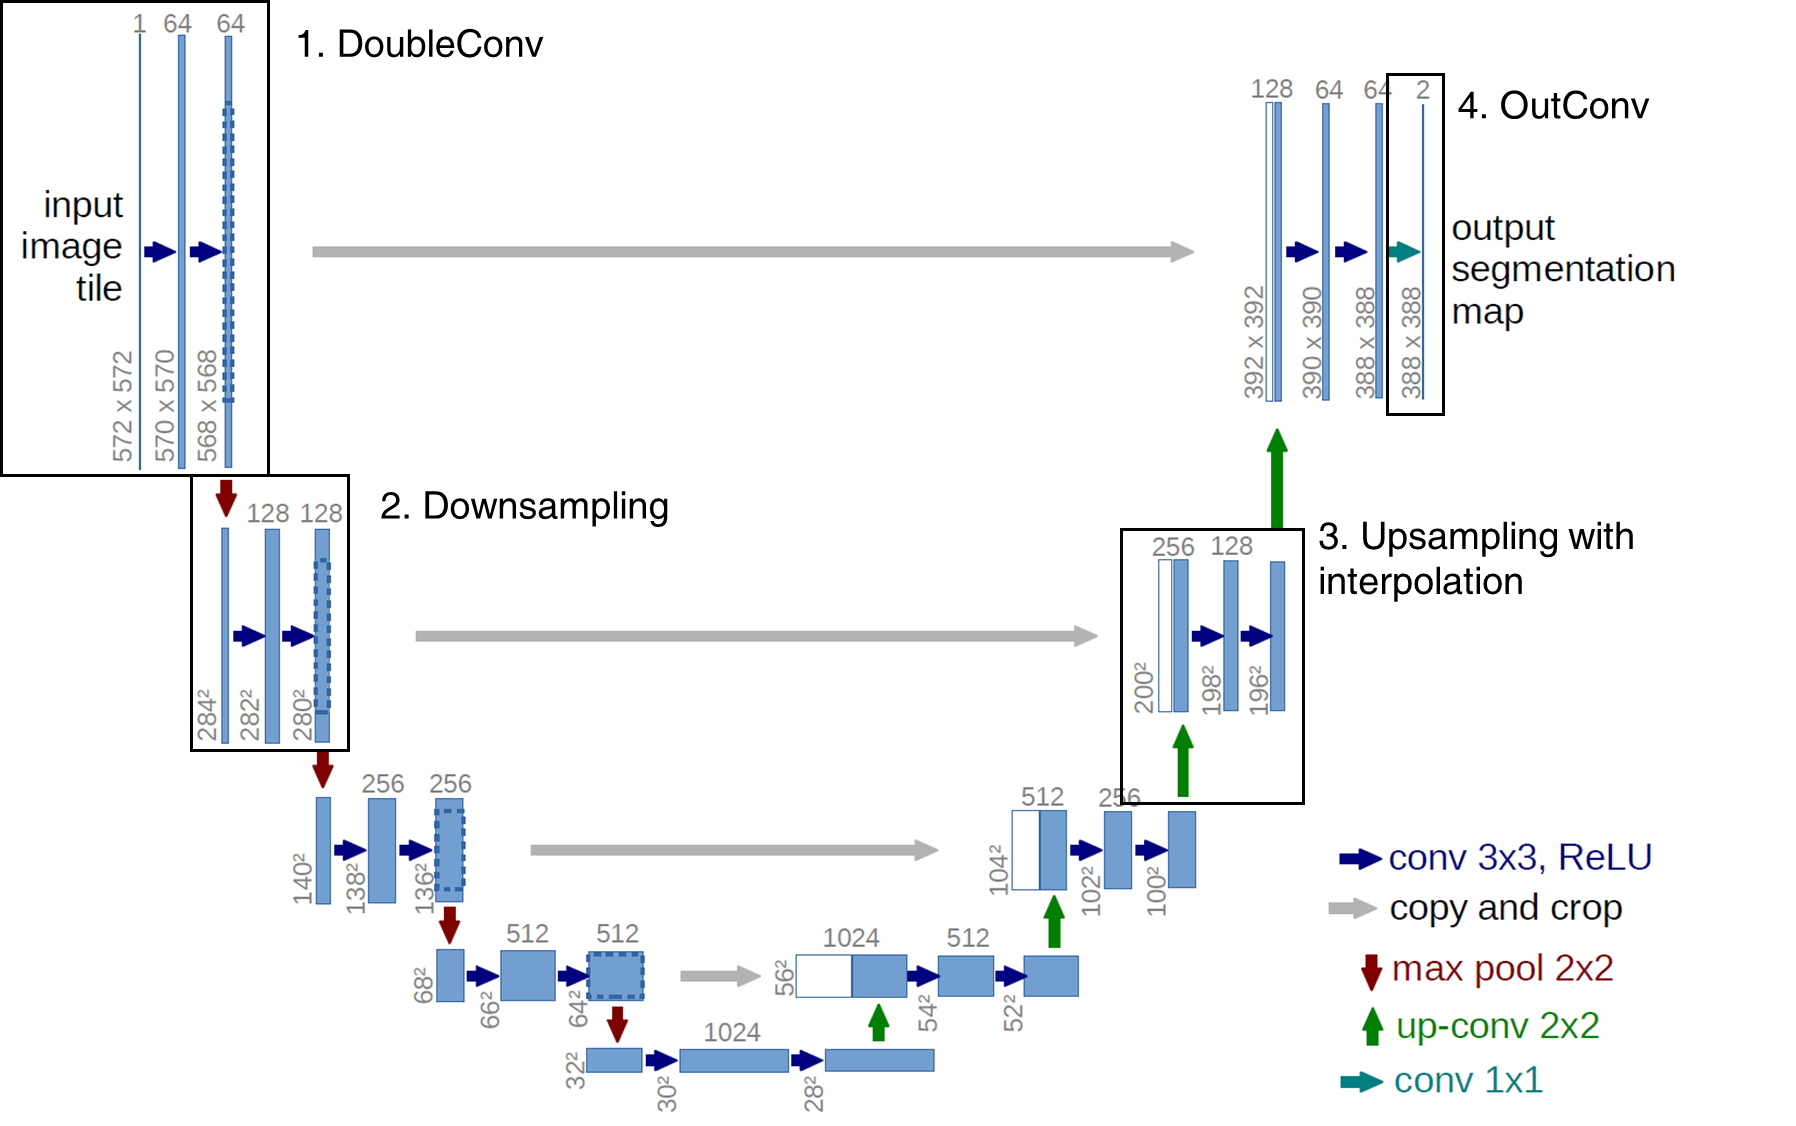

``` python
import torch
import torch.nn as nn
import torch.nn.functional as F
```
- **Key of U-Net implementation**
    1. Double-Convolution : two consecutive 3X3 convolution layer followed by ReLU
    2. Downsampling : 2X2 max-pooling
    3. Upsampling :  2x2 up-convolution
    4. Out-Convolution : Last convolution layer in U-Net (mirroring idea)

**1. Double-Convolution**

```python
class DoubleConv(nn.Module): # nn.Module inheritance
    """(3X3 convolution => [BN] => ReLU) * 2 times"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None): # in_channels, out_channels + mid_channels
        
        super().__init__() # nn.Module(parent class) -> __init__() module execution
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential( # Sequentially Stack Model
            nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1, bias = False), # padding = 1 means padding = same for 3X3 conv.
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, bias = False)
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True)
        )
    
    def forward(self, x):
        return self.double_conv(x)
```

**2. Downsampling**
``` python
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        
        return self.maxpool_conv(x)
```

**3. Upsampling**
- Downsampling & General Resizing -> ```nn.Interpolate()```
- Upsampling -> ```nn.Upsample()``` , ```nn.ConvTranspose2d()```
- ```nn.ConvTranspose2d()``` : element-wise sum after convolution with single elements
- ```nn.functional.pad()``` : 
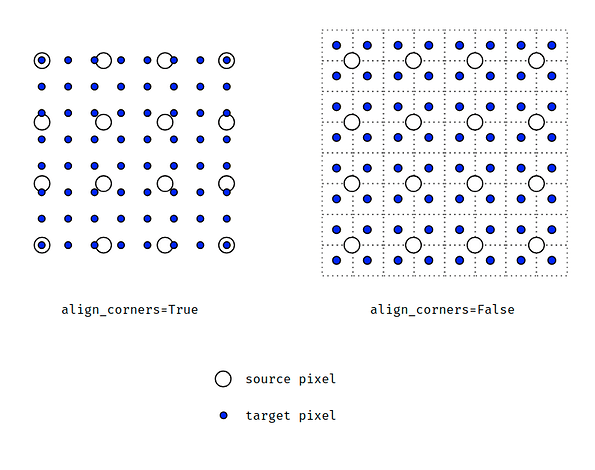
``` python
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear = True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True) # bilinear Interpolation
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is C X H X W
        diffY = x2.size()[2] - x1.size()[2] # difference of Height
        diffX = x2.size()[3] - x1.size()[3] # difference of Width

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, # Pad with diffX, diffY in total to make size of x1, x2 same.
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1) # Direct Connections in U-Net, Channel dimension concat.
        return self.conv(x)
```

**4. OutConv**
``` python
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # 1X1 convolution for output segmentation map

    def forward(self, x):
        return self.conv(x)
 ```

#### U-Net full assembly
``` python
from .unet_parts import *

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1 # Check wheter interpolation is activated
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1) # Down
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4) # Up, U-Net with direct connections
        x = self.up2(x, x3)  
        x = self.up3(x, x2)  
        x = self.up4(x, x1) 
        logits = self.outc(x) # Output logits
        return logits
```

### 02. Implementation of 3D U-Net
1. [Paper](https://arxiv.org/pdf/1606.06650.pdf)
2. [Implementation](https://github.com/wolny/pytorch-3dunet)

- **Concepts**
    - BatchNorm vs GroupNorm
    - Activation Functions : ELU, GeLU, ReLU, LeakyReLU
   
- **BatchNorm vs GroupNorm**
    - BN is effective component in DL.
    - BN normalized the feature by mean, variance within a 'batch'.
    - Normalizing along 'batch dimension' : in small batch size, BN leads to inaccurate estimation of batch statistics.
    - Thus, in such cases, GN can be a alternative to BN.
    - GN divieds the 'channels', not batches into groups & computes with each group the mean & variance for normalization.
    - Since GN computation is independent of batch sizes, thus accuracy is stable in a wide range of batch sizes.
    - Remark : Batch Size = Images/Worker
    - *Other Normalization Techs : Layer Normalization, Instance Normalization*
    <img src= "https://amaarora.github.io/images/GN_BN_LN_IN.png" width = "500dp"></img>

**1. Related Works**
- 3D CNN Hough Voting Approach [Milletari et al.](https://www.researchgate.net/publication/336312306_Hough-CNN_Deep_Learning_for_Segmentation_of_Deep_Brain_Regions_in_MRI_and_Ultrasound)
    - Weakness : Not E2E
- 3D CNN E2E approach for 3D segmentation [Kleesiek et al.](https://pubmed.ncbi.nlm.nih.gov/26808333/)
    - Weakness : Not deep enough, only one pooling layer after first convolution >> multiple scale image segmentation is unavailable.

**2. Contributions**
- Annotates some slices in the volume to be segmented.
- Dense segmentation even when trained with datasets that sparsely annotated training set exists.
- 3D counterpart implementatioin of 2D U-Net
- Elastic deformations for efficient data augmentation during training
    
**3. Architecture and Details**
- Architecture
    - 3D version of 2D U-Net
- Details
    - Inception v2 for bottleneck problem
    - BatchNorm for faster convergence
    - Elastic Deformation for data augmentation

#### Import Packages
```python
# Reference: https://github.com/wolny/pytorch-3dunet/tree/master/pytorch3dunet/unet3d
from functools import partial

import torch
from torch import nn as nn
from torch.nn import functional as F
```

#### 3D Convolution Layer
```python
def conv3d(in_channels, out_channels, kernel_size, bias, padding):
    return nn.Conv3d(in_channels, out_channels, kernel_size, padding = padding, bias = bias)
```
#### Variations of Convolution Layer

order notation : 'r', 'l', 'e', 'c', 'g' combination leads to stacks of layers. <br/>

- 'cr' : Conv+ReLU
- 'gcr' : GroupNorm + Conv + ReLU      
- 'cl' : Conv+LeakyReLU
- 'ce' : Conv+ELU
- 'bcr' : BatchNorm + Conv + ReLU
     
```python
def create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding):
    assert 'c' in order, "Conv Layer MUST BE PRESENT"
    assert order[0] not in 'rle', 'Non-linearlity cannot be the first operation in the layer'
    modules = []
    for i, char in enumerate(order):
        if char == 'r':
            modules.append(('ReLU', nn.ReLU(inplace = True)))
        elif char == 'l':
            modules.append(('LeakyReLU', nn.LeakyRELU(inplace = True)))
        elif char == 'e': # ELU : Exponential Linear Unit. cf. GELU
            modules.append(('ELU', nn.ELU(inplace = True)))
        elif char == 'c':
            # if 'g' in order or 'b' in order(normalization layer in order), bias = False
            # else, bias = True
            bias = not ('g' in order or 'b' in order)
            modules.append(('conv', cov3d(in_channels, out_channels, kernel_size, bias, padding = padding)))
        elif char == 'g':
            # if 'g' appears before than 'c' , normalization layer #channels = in_channels
            is_before_conv = i < order.index('c')
            if is_before_conv : 
                num_channels = in_channels
            else:
                num_channels = out_channels
            if num_channels < num_groups:
                num_groups = 1
            assert num_channels % num_groups == 0, f'Expected number of channels in input to be divisible by num_groups. num_channels={num_channels}, num_groups={num_groups}'
            modules.append(('groupnorm', nn.GroupNorm(num_groups = num_groups, num_channels = num_channels)))
        elif char == 'b':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                modules.append(('batchnorm', nn.BatchNorm3d(in_channels)))
            else:
                modules.append(('batchnorm', nn.BatchNorm3d(out_channels)))
        else:
            raise ValueError(f"Unsupported layer type '{char}'. MUST be one of ['b', 'g', 'r', 'l', 'e', 'c']")
        
    return modules
```

**Remark. Method Overriding**
- $\text{super().__init__() vs super(MyClass,self).__init__()}$ <br/>
- Explicit & Implicit notation difference, no sematic difference.


#### UNet basic block & ResUNet basic block
``` python
class SingleConv(nn.Sequential): #Inheritance : nn.Sequential
    # Order : Group Normalization -> Conv -> ReLU
    def __init__(self, in_channels, out_channels, kernel_size = 3, order = 'gcr', num_groups = 8, padding = 1):
        super(SingleConv, self).__init__() # equivalent with super().__init__()
        
        for name, module in create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding = padding):
            self.add_module(name, module) # add_module is a method of nn.Sequential

class DoubleConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, encoder, kernel_size=3, order = 'gcr', num_groups = 8, padding = 1):
        super(DoubleConv, self).__init__() # equivalent with super().__init__()
        if encoder:
            conv1_in_channels = in_channels
            conv1_out_channels = out_channels // 2
            if conv1_out_channels < in_channels:
                conv1_out_channels = in_channels
            conv2_in_channels, conv2_out_channels = conv1_out_channels, out_channels
        else:
            conv1_in_channels, conv1_out_channels = in_channels, out_channels
            conv2_in_channels, conv2_out_channels = out_channels, out_channels
        self.add_module('SingleConv1', #Conv1
                        SingleConv(conv1_in_channels, conv1_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
        self.add_module('SingleConv2', #Conv2
                        SingleConv(conv2_in_channels, conv2_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
```  
#### Variation of DoubleConv Block : ExtResNetBlock()
- Use ELU instead of ReLU('cge' order, instead of 'gcr')
- Useful Technical Paper : https://arxiv.org/pdf/1706.00120.pdf
- ResUNet fashion block, but why group normalization 'after' convolution?
``` python
class ExtResNetBlock(nn.Module)
    def __init__(self, in_channels, out_channels, kernel_size = 3, order = 'cge', num_groups = 8, **kwargs):
        super(ExtResNetBlock, self).__init__()
        
        self.conv1 = SingleConv(in_channels, out_channels, kernel_size = kernel_size, order = order, num_groups = num_groups)
        self.conv2 = SingleConv(out_channels, out_channels, kernel_size = kernel_size, order = order, num_groups = num_groups)
        # for 3rd block, remove non-linearity since it's gonna be concatenated first.
        n_order = order
        for c in 'rel':
            n_order = n_order.replace(c,'')
        self.conv3 = SingleConv(out_channels, out_channels, kernel_size = kernel_size, order = n_order, num_groups = num_groups)
        # then create non-linearity separately
        if 'l' in order:
            self.non_linearity = nn.LeakyReLU(negative_slope = 0.1, inplace = True)
        elif 'e' in order:
            self.non_linearity = nn.ELU(inplace = True)
        else:
            self.non_linearity = nn.ReLU(inplace = True)
    def forward(self, x):
        out = self.conv1(x)
        residual = out
        out = self.conv2(out)
        out = self.conv3(out)
        
        out += residual #its dimension are comaptible because conv2, conv3 layer does not change dimensionality.
        out = self.non_linearity(out)
        
        return out       
```

### 03. Implementation of various data augmentation methods

```python
# Reference: https://github.com/wolny/pytorch-3dunet/blob/master/pytorch3dunet/augment/transforms.py
import importlib
import random

import numpy as np
import torch
from scipy.ndimage import rotate, map_coordinates, gaussian_filter, convolve
from skimage import measure
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries
```

**Define Compose Class**
``` python
GLOBAL_RANDOM_STATE = np.random.RandomState(47) # Code reproducibility when random augmentation
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, m): # call magic method, when this class is called -> this method will be executed.
        for t in self.transforms:
            m = t(m)
        return m
```

**1. Random Flip**

- Concepts <br/>
    - ```numpy.random.RandomState ``` <br/>
    - ```numpy.random.RandomState.uniform()``` <br/>
    - ```numpy.flip()``` <br/>
    - ```numpy.stack()``` <br/>
    - ```assert``` <br/>
    - ```kwargs``` <br/>

``` python
# Random Flip Implementation
class RandomFlip:
    '''
    randomly flip images across the given axes.
    3D or 4D image can also be flipped.
    '''
    
    def __init__(self, random_state, axis_prob = 0.5, **kwargs):
        assert random_state is not None, 'RandomState cannot be None'
        self.random_state = random_state
        self.axes = (0,1,2)
        self.axis_prob = axis_prob
        
    def __call__(self, m):
        assert m.ndim in [3,4], 'Supports only 3D(DxHxW) or 4D(CxDxHxW) images'
        
        for axis in self.axes:
            if self.random_state.uniform() > self.axis_prob:
                if m.ndim == 3:
                    m = np.flip(m, axis)
                else:
                    channels = [np.flip(m[c], axis) for c in range(m.shape[0])]
                    m = np.stack(channels, axis = 0)
        
        return m
```

**2. RandomRotate90, RandomRotate**
- Concepts
    - ```np.rot90()```
    - ```np.stack()```
    - ```scipy.ndimage.rotate()```
    - **$\text{__call__}$** magic method is invoked when the instance of a class is invoked. 

```python
class RandomRotate90:
    
    def __init__(self, random_state, **kwargs):
        self.random_state = random_state
        self.axis = (1,2) # always around z-axis
        
    def __call__(self, m):
        assert m.ndim in [3,4], 'Supports onlly 3D (DxHxw) or 4D(CxDxHxW) images'
        
        k = self.random_state.randint(0,4)
        if m.ndim == 3:
            m = np.rot90(m,k, self.axis)
            
        else:
            channels = [np.rot90(m[c], k, self.axis) for c in range(m.shape[0])]
            m = np.stack(channels, axis = 0)
            
        return m
```

``` python
class RandomRotate:
    ''' 
    Rotate an array by a random degree.
    '''
    def __init__(self, random_state, angle_spectrum = 30, axes = None, mode = 'reflect', order = 0, **kwargs):
        if axes is None:
            axes = [(1,0), (2,1), (2,0)]
        
        else:
            assert isinstance(axes, list) and len(axes) > 0
            # if axes is list format and axes has more than 1 elements, no error asserted
            
            self.random_state = random_state
            self.angle_spectrum = angle_spectrum
            self.axes = axes
            self.mode = mode
            self.order = order
            
    def __call__(self, m):
        axis = self.axes[self.random_state.randint(len(self.axes))] # select random axis
        angle = self.randome_state.randint(-self.angle_spectrum, self.angle_spectrum) # random angle
        
        if m.ndim == 3: # rotate : scipy.ndimage.rotate()
            m = rotate(m, angle, axes = axis, reshape = False, order = self.order, mode = self.mode, cval = -1)
        else: # for 4D(BatchXChannelsXHeightXWidth), iterate for all tensors in batch and stack them.
            channels = [rotate(m[c], angle, axes = axis, reshape = False, order = self.order, mode = self.mode, cval = -1) for c in range(m.shape[0])]
            m = np.stack(channels, axis = 0)
        
        return m
```

**3. Elastic Deformation**
- Concepts
    - ```guassian_filter()```
    - ```np.meshgrid()```
    - ```scipy.ndimage.map_coordinates()```
    
- How does elastic deformation works?
    For 2D,
    - $\Delta_x(n,m) = G(\sigma)*(\alpha \times Rand(n,m))$
    - $\Delta_y(n,m) = G(\sigma)*(\alpha \times Rand(n,m))$
    - $I_{trans} (j+\Delta_x (j,k), k+\Delta_y (j,k)) = I(j,k)$

```python
class ElasticDeformation:
    
    def __init__(
        self, random_state, spline_order, 
        alpha = 2000, sigma = 50, execution_probability = 0.1,
        **kwargs
    ):
        
        self.random_state = random_state
        self.spline_order = spline_order
        self.alpha = alpha
        self.sigma = sigma
        self.execution_probability = execution_probability
        self.apply_3d = apply_3d
    
    def __call__(self, m):
        if self.random_state.uniform() < self.execution_probability:
            assert m.ndim in [3,4]
            if m.ndim == 3:
                volume_shape = m.shape
            else:
                volume_shape = m[0].shape
            
            if self.apply_3d:# * unpacks tuples
                dz = gaussian_filter(self.random_state.randn(*volume_shape), self.sigma, mode="reflect") * self.alpha
            else:
                dz = np.zeros_like(m)
            
            dy, dx = [
                gaussian_filter(
                    self.random_state.randn(*volume_shape),
                    self.sigma, mode = "reflect"
                ) * self.alpha for _ in range(2)
            ]
            
            z_dim, y_dim, x_dim = volume_shape
            z, y, x = np.meshgrid(np.arange(z_dim), np.arange(y_dim), np.arange(x_dim), indexing = 'ij')
            indices = z+dz, y+dy, x+dx
            
            if m.ndim == 3:
                return map_coordinates(m, indices, order = self.spline_order, mode = 'reflect')
            else;
                channels = [map_coordinates(c, indices, order = self.spline_order, mode = 'reflect') for c in m]
                return np.stack(channels, axis = 0)
        
        return m
```

### 04. U-Net Real Training
Supplementary Materials, *Junha Park* <br/>
[Reference](https://www.kaggle.com/c/data-science-bowl-2018/data) : Kaggle data science bowl 2018 Round 1 <br/>

In [2]:
import os
import time
import copy
import torch
import shutil
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform
import cv2

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import sys
sys.executable

'/home/mars/anaconda3/envs/molly/bin/python'

### Load Data with Dataset

In [4]:
def get_transforms(mean, std):
    list_transforms = []
    list_transforms.extend(
        [
            HorizontalFlip(p=0.5)
        ]
    )
    list_transforms.extend(
        [
            Normalize(mean = mean, std = std, p=1),
            ToTensorV2(),
        ]
    )
    return Compose(list_transforms)

In [56]:
class Nuclei_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)
    
    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        img = io.imread(image_path)[:,:,:3].astype('float32')
        img = transform.resize(img, (128,128))
        mask = self.get_mask(mask_folder, 128, 128).astype('float32')
        augmented = self.transforms(image = img, mask = mask)
        img = augmented['image']
        mask = augmented['mask']
        #print(mask.shape)
        mask = mask.permute(2,0,1)
        
        return (img, mask)
    
    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask, mask_)
        return mask

In [57]:
base_dir = '/home/mars/jupyter-home/Junha Park/train'
data = Nuclei_dataset(base_dir)


In [58]:
print(data.__len__())
data.__getitem__(0)

670


/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


(tensor([[[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602,

In [59]:
for img, msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


In [60]:
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image = std*image + mean
    image = image.clip(0,1)
    image = (image*255).astype(np.uint8)
    return image

In [61]:
trainset, valset = random_split(data, [580, 90])
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


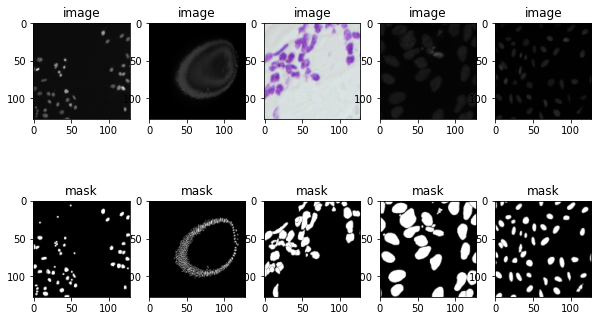

In [62]:
def plot_img(dataloader, no_):
    iter_ = iter(dataloader)
    images, masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(no_):
        image = image_convert(images[idx])
        plt.subplot(2, no_, idx+1)
        plt.title('image')
        plt.imshow(image)
    for idx in range(no_):
        mask = mask_convert(masks[idx])
        plt.subplot(2, no_, idx+no_+1)
        plt.title('mask')
        plt.imshow(mask, cmap='gray')
    plt.show()
    
plot_img(train_loader, 5)

In [65]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Contraction
        self.dblock1 = self.double_conv(3, 64)
        self.dblock2 = self.double_conv(64, 128)
        self.dblock3 = self.double_conv(128,256)
        self.dblock4 = self.double_conv(256,512)
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 
        
        # Inflation
        self.dblock5 = self.double_conv(256 + 512, 256)
        self.dblock6 = self.double_conv(128 + 256, 128)
        self.dblock7 = self.double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        # out = self.sigmoid(x)
        return out
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

In [66]:
model = Unet().to(device)
model

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2,

In [67]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou    

In [68]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [69]:
checkpoint_path = '/home/mars/jupyter-home/Junha Park/model'
best_model_path = '/home/mars/jupyter-home/Junha Park/bestmodel/bestmodel.pt'
epochs = 20
criterion = DiceBCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275

train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/20


/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
/home/mars/anaconda3/envs/molly/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss : 0.5904110885899643 iou : 0.14500497600250786
Validation loss : 0.4966915316051907 iou : 0.2373165815543217
Validation loss decreased (3.952750 --> 0.496692).  Saving model ...
4m 49s
Epoch 2/20
Train loss : 0.4339368399874917 iou : 0.26748055894694406
Validation loss : 0.42316050993071663 iou : 0.3167821039743521
Validation loss decreased (0.496692 --> 0.423161).  Saving model ...
4m 43s
Epoch 3/20
Train loss : 0.41821477074047614 iou : 0.31838400430095665
Validation loss : 0.5134963393211365 iou : 0.2741511409593193
4m 45s
Epoch 4/20
Train loss : 0.3531983407406971 iou : 0.3766296065145763
Validation loss : 0.2686196168263753 iou : 0.4572452862184487
Validation loss decreased (0.423161 --> 0.268620).  Saving model ...
4m 46s
Epoch 5/20
Train loss : 0.2934944547455886 iou : 0.48411349513576285
Validation loss : 0.2399196591642168 iou : 0.49514479019126667
Validation loss decreased (0.268620 --> 0.239920).  Saving model ...
4m 50s
Epoch 6/20
Train loss : 0.28567374497652054

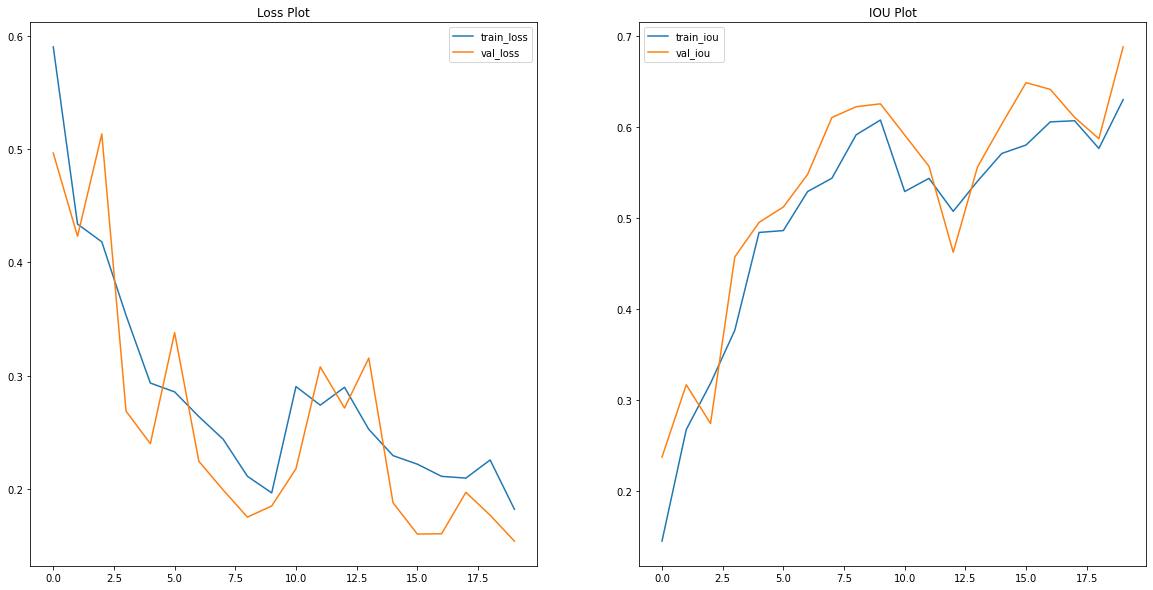

In [70]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [ ]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()